# Анализ сотрудников компании «Работа с заботой»

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом. Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании.

Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

**Задачи:**
1) Предсказание уровня удовлетворённости сотрудника: необходимо построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

2) Предсказание увольнения сотрудника из компании: необходимо построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**План:**

*Задача 1*
1. <a href="1">Загрузка данных</a>
2. <a href="2">Предобработка данных</a>
3. <a href="3">Исследовательский анализ данных</a>
4. <a href="4">Подготовка данных</a>
5. <a href="5">Обучение моделей</a>
6. <a href="6">Промежуточные выводы</a>

*Задача - 2*
1. <a href="2.1">Загрузка данных</a>
2. <a href="2.2">Предобработка данных</a>
3. <a href="2.3">Исследовательский анализ данных:</a>
- <a href="2.3.1">Проведите исследовательский анализ данных.</a>
- <a href="2.3.2">Составьте портрет «уволившегося сотрудника».</a>
- <a href="2.3.3">Проверьте это утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.</a>
4. <a href="2.4">Добавление нового входного признака</a>
5. <a href="2.5">Подготовка данных</a>
6. <a href="2.6">Обучение модели</a>
7. <a href="2.7">Промежуточные выводы</a>

<a href="3">*Общий вывод*</a>

In [ ]:
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install shap -q

In [ ]:
import pandas as pd
import numpy as np
import os
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy. stats import ttest_ind
import tqdm as notebook_tqdm
import phik
from phik import phik_matrix

from sklearn.dummy import (DummyRegressor,
                           DummyClassifier)
from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (LogisticRegression,
                                  LinearRegression)
from sklearn.neighbors import (KNeighborsClassifier,
                               KNeighborsRegressor)
from sklearn.tree import (DecisionTreeClassifier,
                          DecisionTreeRegressor)
from sklearn.svm import (SVC,
                         SVR)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (roc_auc_score,
                             make_scorer)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(rc={'figure.figsize': (20, 10)})


RANDOM_STATE = 42
TEST_SIZE = 0.25

# *Задача 1*

## 1. Загрузка данных
<a href="1"></a>

In [ ]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [ ]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [ ]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [ ]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


## 2. Предобработка данных
<a href="2"></a>

In [ ]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [ ]:
train_job_satisfaction_rate.duplicated().sum()

0

In [ ]:
train_job_satisfaction_rate['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [ ]:
train_job_satisfaction_rate['dept'].isnull().sum()

6

In [ ]:
train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [ ]:
train_job_satisfaction_rate['level'].isnull().sum()

4

In [ ]:
train_job_satisfaction_rate['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [ ]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
test_features.duplicated().sum()

0

In [ ]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [ ]:
test_features['dept'].isnull().sum()

2

In [ ]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [ ]:
test_features['level'].isnull().sum()

1

In [ ]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [ ]:
test_features['workload'].isnull().sum()

0

In [ ]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Вывод:**

1)train_job_satisfaction_rate:
- явных и неявных дубликатов нет;
- пропущены значения в dept (6), в level (4).

2)test_features:
- явных дубликатов нет;
- видим ' ' в столбцах dept, workload;
- пропущены значения в dept (2), в level (1).

3)test_target_job_satisfaction_rate:
- изменений нет.

## 3. Исследовательский анализ
<a href="3"></a>

In [ ]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [ ]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


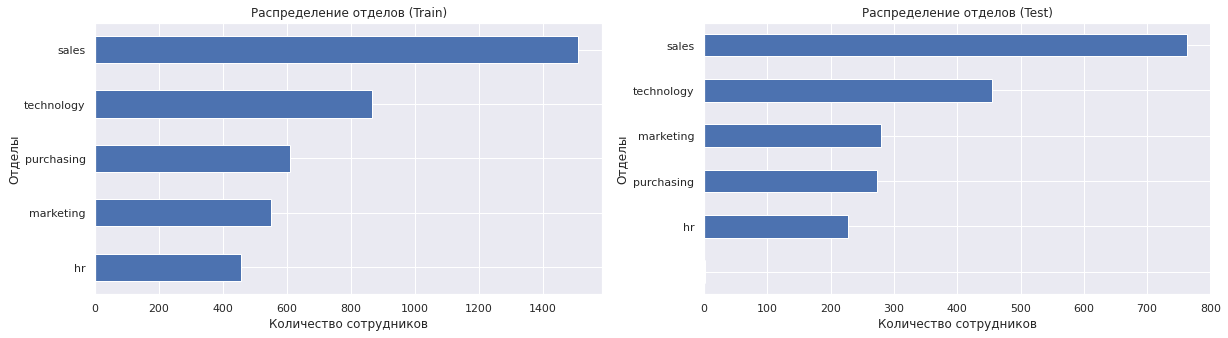

In [ ]:
data1 = train_job_satisfaction_rate['dept'].value_counts().sort_values()
data2 = test_features['dept'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение отделов (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Отделы')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение отделов (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Отделы')

plt.show()

Распределение тестовой и тренировчной выборок схоже. Однако, в тренировочной выборке количество сотрудников в отделе закупок больше, чем в отделе маркетинга. А в тестовой выборке, наоборот, количество сотрудников в отделе маркетинга больше, чем в отделе закупок.

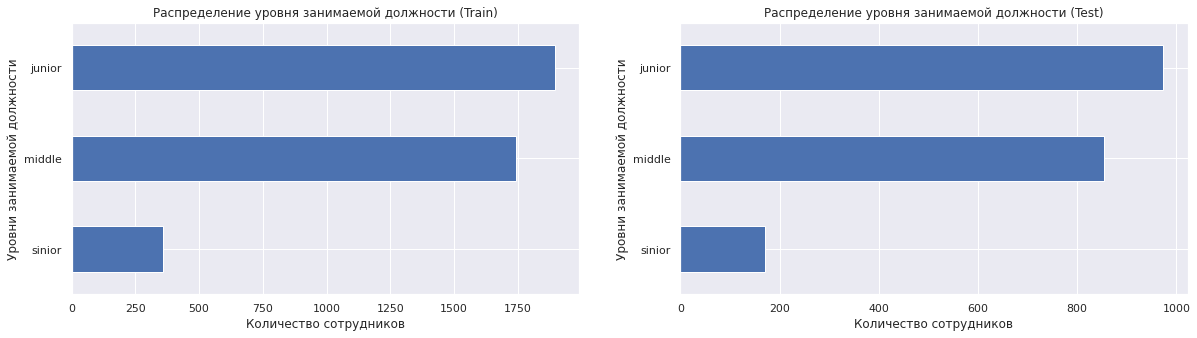

In [ ]:
data1 = train_job_satisfaction_rate['level'].value_counts().sort_values()
data2 = test_features['level'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение уровня занимаемой должности (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Уровни занимаемой должности')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение уровня занимаемой должности (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Уровни занимаемой должности')

plt.show()

Старших специалистов сильно меньше, чем остальных. Структуры тренировочной и тестовой выборок похожи.

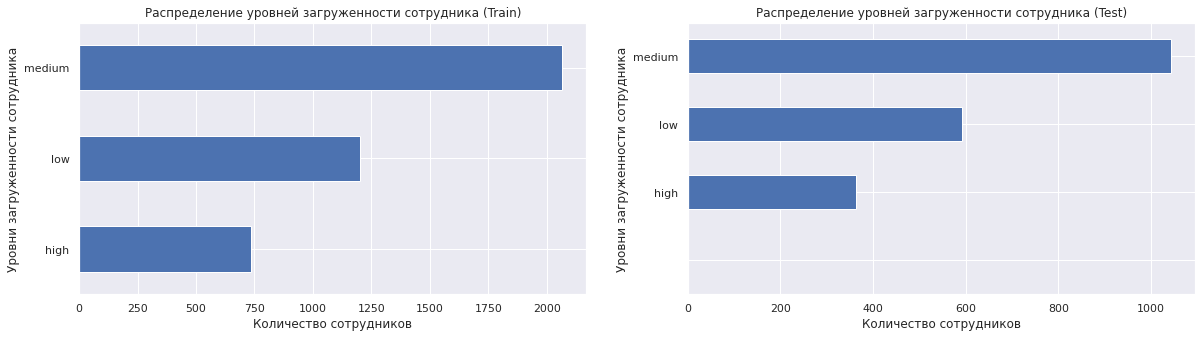

In [ ]:
data1 = train_job_satisfaction_rate['workload'].value_counts().sort_values()
data2 = test_features['workload'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение уровней загруженности сотрудника (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Уровни загруженности сотрудника')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение уровней загруженности сотрудника (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Уровни загруженности сотрудника')

plt.show()

Высоконагруженных специалистов меньше всего.

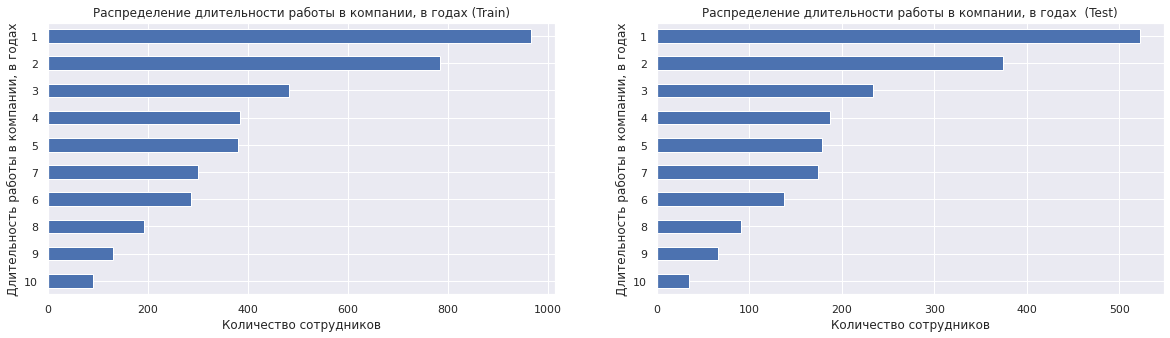

In [ ]:
data1 = train_job_satisfaction_rate['employment_years'].value_counts().sort_values()
data2 = test_features['employment_years'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение длительности работы в компании, в годах (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Длительность работы в компании, в годах')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение длительности работы в компании, в годах  (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Длительность работы в компании, в годах')

plt.show()

В компании много новичков. С увеличением длительности работы в компании, снижается количество сотрудников.

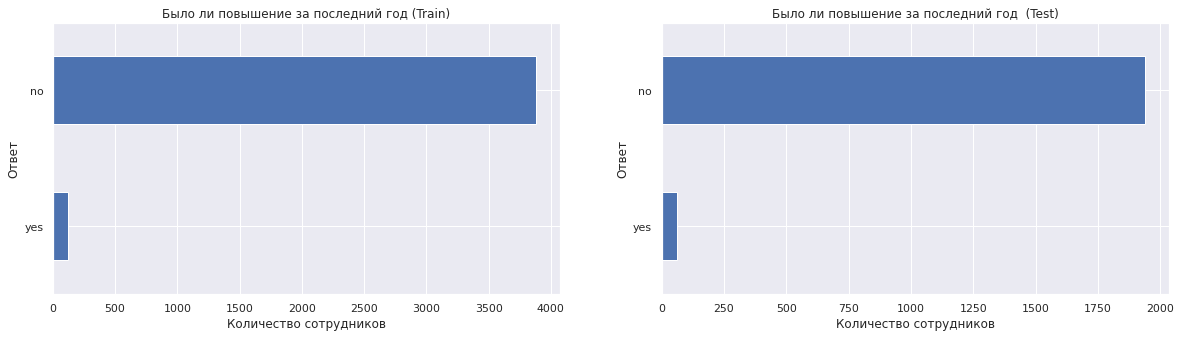

In [ ]:
data1 = train_job_satisfaction_rate['last_year_promo'].value_counts().sort_values()
data2 = test_features['last_year_promo'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Было ли повышение за последний год (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Ответ')

data2.plot.barh(ax=ax2)
ax2.set_title('Было ли повышение за последний год  (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Ответ')

plt.show()

Видим, что минимальное количество сотрудников получили повышение.

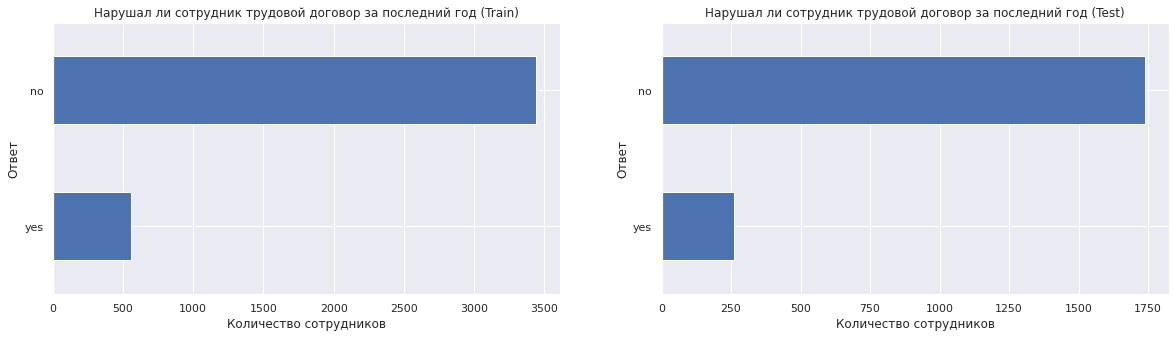

In [ ]:
data1 = train_job_satisfaction_rate['last_year_violations'].value_counts().sort_values()
data2 = test_features['last_year_violations'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Нарушал ли сотрудник трудовой договор за последний год (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Ответ')

data2.plot.barh(ax=ax2)
ax2.set_title('Нарушал ли сотрудник трудовой договор за последний год (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Ответ')

plt.show()

Сотрудники почти не нарушают трудовой договор.

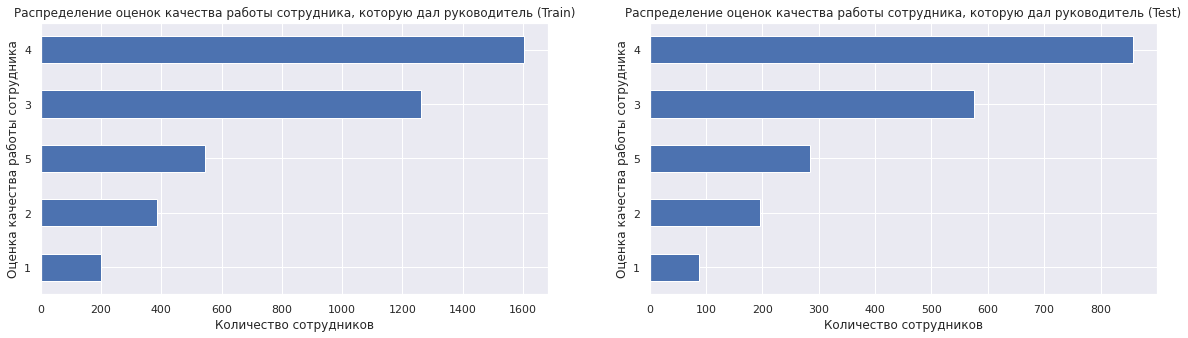

In [ ]:
data1 = train_job_satisfaction_rate['supervisor_evaluation'].value_counts().sort_values()
data2 = test_features['supervisor_evaluation'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение оценок качества работы сотрудника, которую дал руководитель (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Оценка качества работы сотрудника')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение оценок качества работы сотрудника, которую дал руководитель (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Оценка качества работы сотрудника')

plt.show()

Преобладают средние и высокие оценки.

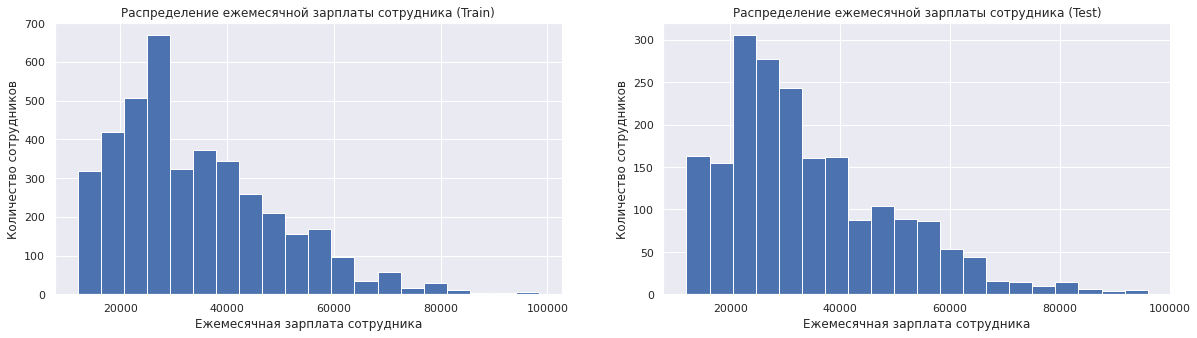

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

train_job_satisfaction_rate['salary'].hist(ax=ax1, bins=20)
ax1.set_title('Распределение ежемесячной зарплаты сотрудника (Train)')
ax1.set_xlabel('Ежемесячная зарплата сотрудника')
ax1.set_ylabel('Количество сотрудников')

test_features['salary'].hist(ax=ax2, bins=20)
ax2.set_title('Распределение ежемесячной зарплаты сотрудника (Test)')
ax2.set_xlabel('Ежемесячная зарплата сотрудника')
ax2.set_ylabel('Количество сотрудников')

plt.show()

С повышением уровня зарплат, снижается количество сотрудников.

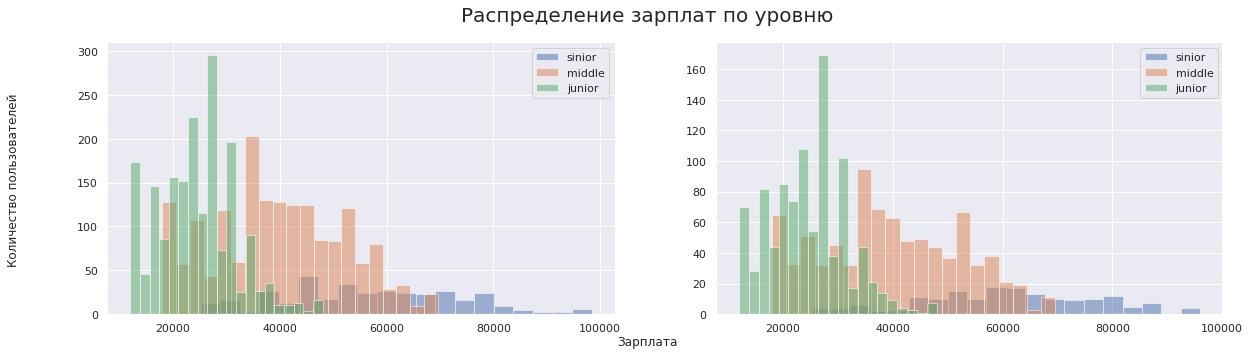

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
f.suptitle('Распределение зарплат по уровню', fontsize=20)

f.text(0.5, 0.04, 'Зарплата', ha='center')
f.text(
    0.06,
    0.5,
    'Количество пользователей',
    ha='center',
    va='center',
    rotation='vertical',
)

ax1.hist(
    train_job_satisfaction_rate.query('level == "sinior"')['salary'],
    bins=20,
    alpha=0.5,
    label='sinior',
)
ax1.hist(
    train_job_satisfaction_rate.query('level == "middle"')['salary'],
    bins=20,
    alpha=0.5,
    label='middle',
)
ax1.hist(
    train_job_satisfaction_rate.query('level == "junior"')['salary'],
    bins=20,
    alpha=0.5,
    label='junior',
)
ax1.legend()

ax2.hist(
    test_features.query('level == "sinior"')['salary'],
    bins=20,
    alpha=0.5,
    label='sinior',
)
ax2.hist(
    test_features.query('level == "middle"')['salary'],
    bins=20,
    alpha=0.5,
    label='middle',
)
ax2.hist(
    test_features.query('level == "junior"')['salary'],
    bins=20,
    alpha=0.5,
    label='junior',
)
ax2.legend()

plt.show()

Зарплата также зависит от уровня занимаемой должности. Квалификация сотрудника повышает шанс получить более высокую зарплату.

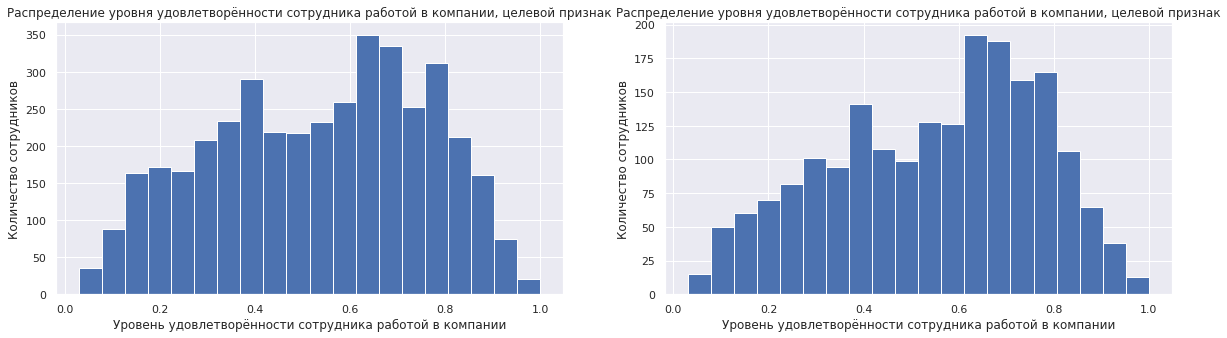

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

train_job_satisfaction_rate['job_satisfaction_rate'].hist(ax=ax1, bins=20)
ax1.set_title('Распределение уровня удовлетворённости сотрудника работой в компании, целевой признак')
ax1.set_xlabel('Уровень удовлетворённости сотрудника работой в компании')
ax1.set_ylabel('Количество сотрудников')

test_target_job_satisfaction_rate['job_satisfaction_rate'].hist(ax=ax2, bins=20)
ax2.set_title('Распределение уровня удовлетворённости сотрудника работой в компании, целевой признак')
ax2.set_xlabel('Уровень удовлетворённости сотрудника работой в компании')
ax2.set_ylabel('Количество сотрудников')

plt.show()

Сотрудники в целом скорее удовлетворены работой.

**Корреляционный анализ**

In [ ]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


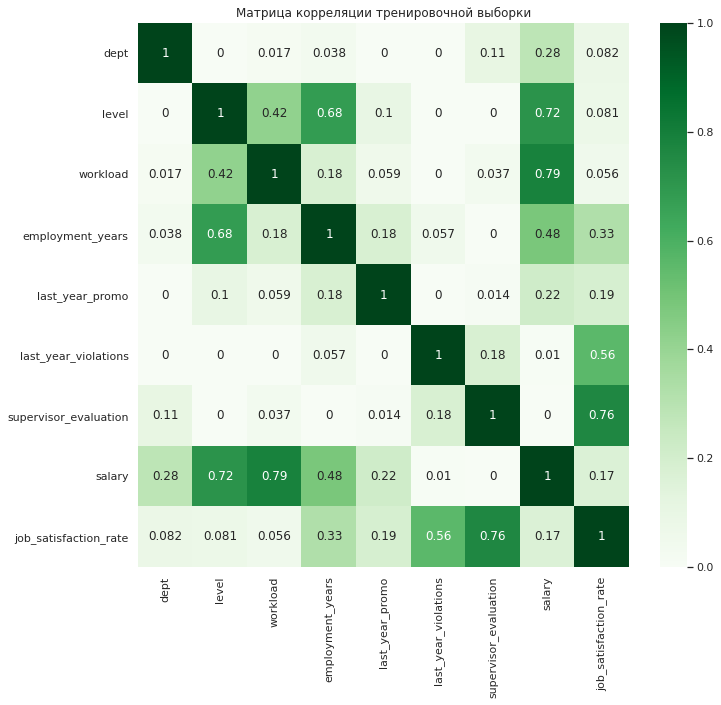

In [ ]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.title('Матрица корреляции тренировочной выборки')
sns.heatmap(train_job_satisfaction_rate.drop(columns=['id']).phik_matrix(interval_cols=
    ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']),
    annot=True,
    cmap="Greens");

Наблюдается высокая корреляция уровня загрузки и зарплаты, но не превышает критического значения.

In [ ]:
test_features = pd.merge(test_features, test_target_job_satisfaction_rate, on='id', sort=True)
print(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.80
1,100480,marketing,junior,low,4,no,no,4,16800,0.84
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79
3,100610,sales,middle,medium,5,no,no,4,43200,0.75
4,100692,sales,middle,high,6,no,no,4,48000,0.69


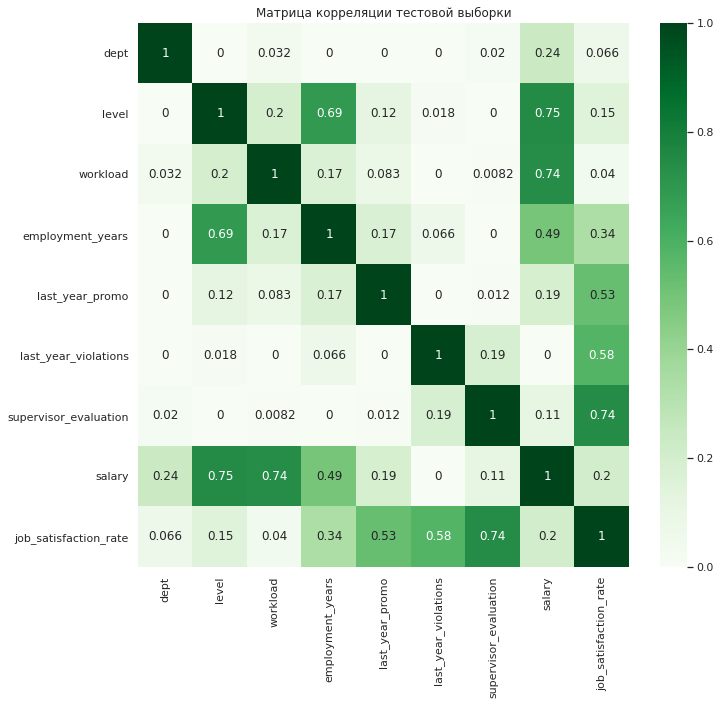

In [ ]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.title('Матрица корреляции тестовой выборки')
sns.heatmap(test_features.drop(columns=['id']).phik_matrix(interval_cols=
    ['employment_years', 'supervisor_evaluation', 'salary']),
    annot=True,
    cmap="Greens");

Наблюдается высокая корреляция уровня загрузки и зарплаты. Она не превышает критического значения. Также для задач классификации мультиколинеарность не так уж и важна. Оставляем все переменные.

**Вывод:**

1)train_job_satisfaction_rate и test_features:
- `dept:`
Распределение тестовой и тренировчной выборок схоже. Однако, в тренировочной выборке количество сотрудников в отделе закупок больше, чем в отделе маркетинга. А в тестовой выборке, наоборот, количество сотрудников в отделе маркетинга больше, чем в отделе закупок.
- `level:`
Старших специалистов сильно меньше, чем остальных. Структуры тренировочной и тестовой выборок похожи.
- `workload:`
Высоконагруженных специалистов меньше всего.
- `employment_years:`
В компании много новичков. С увеличением длительности работы в компании, снижается количество сотрудников.
- `last_year_promo:`
Видим, что минимальное количество сотрудников получили повышение.
- `last_year_violations:`
Сотрудники почти не нарушают трудовой договор.
- `supervisor_evaluation:`
Преобладают средние и высокие оценки.
- `salary:`
С повышением уровнязарплат, снижается количество сотрудников.
- `Распределение зарплат по уровню квалификации:`
Зарплата также зависит от уровня занимаемой должности. Квалификация сотрудника повышает шанс получить более высокую зарплату.


2)train_job_satisfaction_rate и test_target_job_satisfaction_rate:
- `job_satisfaction_rate:`
Сотрудники в целом скорее удовлетворены работой.

3)корреляционный анализ:
- `train_job_satisfaction_rate:`
Наблюдается высокая корреляция уровня загрузки и зарплаты, но не превышает критического значения.
- `test_features:`
Наблюдается высокая корреляция уровня загрузки и зарплаты. Она не превышает критического значения. Также для задач классификации мультиколинеарность не так уж и важна. Оставляем все переменные.

## 4. Подготовка данных
<a href="4"></a>

In [ ]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [ ]:
if 'id' in train_job_satisfaction_rate.columns:
    train_job_satisfaction_rate = train_job_satisfaction_rate.drop('id', axis=1)

In [ ]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


In [ ]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


In [ ]:
if 'id' in test_features.columns:
    test_features = test_features.drop('id', axis=1)

In [ ]:
test_features = test_features.drop_duplicates()
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1917 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1915 non-null   object 
 1   level                  1916 non-null   object 
 2   workload               1917 non-null   object 
 3   employment_years       1917 non-null   int64  
 4   last_year_promo        1917 non-null   object 
 5   last_year_violations   1917 non-null   object 
 6   supervisor_evaluation  1917 non-null   int64  
 7   salary                 1917 non-null   int64  
 8   job_satisfaction_rate  1917 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 149.8+ KB


In [ ]:
print(train_job_satisfaction_rate.shape)
print(test_features.shape)
print(test_target_job_satisfaction_rate.shape)

(3755, 9)
(1917, 9)
(2000, 2)


In [ ]:
X_train_1 = train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_train_1 = train_job_satisfaction_rate['job_satisfaction_rate']

In [ ]:
X_test_1 = test_features.drop('job_satisfaction_rate', axis=1)
y_test_1 = test_features['job_satisfaction_rate']

In [ ]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [ ]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [ ]:
pipe_final.fit(X_train_1, y_train_1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', RobustScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models', LinearRegression())])

In [ ]:
score = pipe_final.score(X_test_1, y_test_1)
print(f"R^2 score на тестовых данных: {score}")

R^2 score на тестовых данных: 0.6119603007029939


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train_1_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_1), columns=data_preprocessor.get_feature_names_out())
X_train_1_transformed.info()

In [ ]:
X_test_1_transformed = pd.DataFrame(data_preprocessor.transform(X_test_1), columns=data_preprocessor.get_feature_names_out())
X_test_1_transformed.info()

## 5. Обучение моделей
<a href="5"></a>

In [ ]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum( np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2) )

smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

In [ ]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

Определим лучшую модель и проверьте её качество с помощью метрики SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).
Критерий успеха: SMAPE ≤15 на тестовой выборке.

In [ ]:
rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
rs.fit(X_train_1, y_train_1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': [None, 2, 3, 4, 5,
                                                               6],
                                         'models__max_features': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [ ]:
print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', rs.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [ ]:
all_model_1 = pd.DataFrame(rs.cv_results_).sort_values(by=['rank_test_score'])
pd.set_option('display.max_colwidth', None)
all_model_1[['rank_test_score',
    'param_models',
    'params'
]].head(10)

,rank_test_score,param_models,params
1,1,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=42)}"
6,2,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 7, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=42)}"
7,3,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=42)}"
5,4,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__max_features': 14, 'models__max_depth': 5, 'models': DecisionTreeRegressor(random_state=42)}"
0,5,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=42)}"
2,6,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=42)}"
3,7,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__max_features': 7, 'models__max_depth': 2, 'models': DecisionTreeRegressor(random_state=42)}"
4,7,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 11, 'models__max_depth': 2, 'models': DecisionTreeRegressor(random_state=42)}"
8,7,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeRegressor(random_state=42)}"
9,10,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__max_features': 8, 'models__max_depth': 2, 'models': DecisionTreeRegressor(random_state=42)}"


In [ ]:
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test_1, rs.predict(X_test_1)),4)}')

Метрика SMAPE лучшей модели на тестовой выборке: 14.9072


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучшей моделью определена: `DecisionTreeRegressor(random_state=42)`

с параметрами: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=42)}`

Качество модели удовлетворяет критерию успеха SMAPE ≤ 15 на тестовой выборке: `14.9072`

## 6. Оформление выводов
<a href="6"></a>

Для начала загрузили данные и посмотрели общую информацию.
На этапе предобработки проверили есть ли явные и неявные дубликаты, заменили ' ' на nan.
Провели исследовательский и корреляционный анализ. Аномалий и мультиколинеарность не обнаружены.

В процессе обучения моделей и подбора параметров работа производилась для:
1. LinearRegression()
2. DecisionTreeRegressor()

Лучшей моделью определена: `DecisionTreeRegressor(random_state=42)`

с параметрами: `{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': None, 'models': DecisionTreeRegressor(random_state=42)}`

Качество модели удовлетворяет критерию успеха SMAPE ≤ 15 на тестовой выборке: `14.9072`

# *Задача 2*

## 1. Загрузка данных
<a href="2.1"></a>

In [ ]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [ ]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [ ]:
test_features_q = pd.read_csv('/datasets/test_features.csv')
test_features_q.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
test_features_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


## 2. Предобработка данных
<a href="2.2"></a>

In [ ]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [ ]:
train_quit.duplicated().sum()

0

In [ ]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [ ]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [ ]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [ ]:
test_features_q.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
test_features_q.duplicated().sum()

0

In [ ]:
test_features_q['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [ ]:
test_features_q['dept'].isna().sum()

2

In [ ]:
test_features_q['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [ ]:
test_features_q['level'].isna().sum()

1

In [ ]:
test_features_q['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [ ]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [ ]:
test_target_quit.duplicated().sum()

0

**Вывод:**

1)train_quit:
- явных и неявных дубликатов нет;

2)test_features_q:
- явных дубликатов нет;
- видим ' ' в столбцах dept, workload;
- пропущены значения в dept (2), в level (1).

3)test_target_quit:
- изменений нет.

## 3. Исследовательский анализ
<a href="2.3"></a>

**3.1. Анализ всех категорий**
<a href="2.3.1"></a>

In [ ]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [ ]:
test_features_q.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


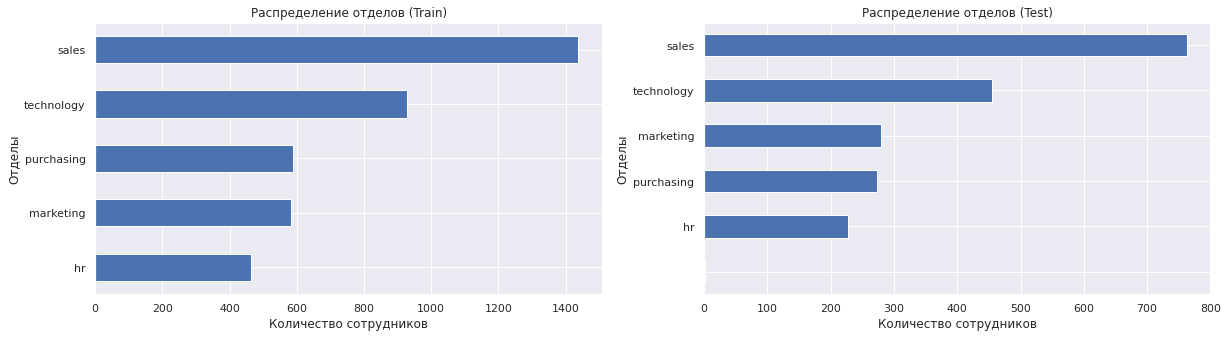

In [ ]:
data1 = train_quit['dept'].value_counts().sort_values()
data2 = test_features_q['dept'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение отделов (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Отделы')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение отделов (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Отделы')

plt.show()

Видно, что структура в целом очень похожа.

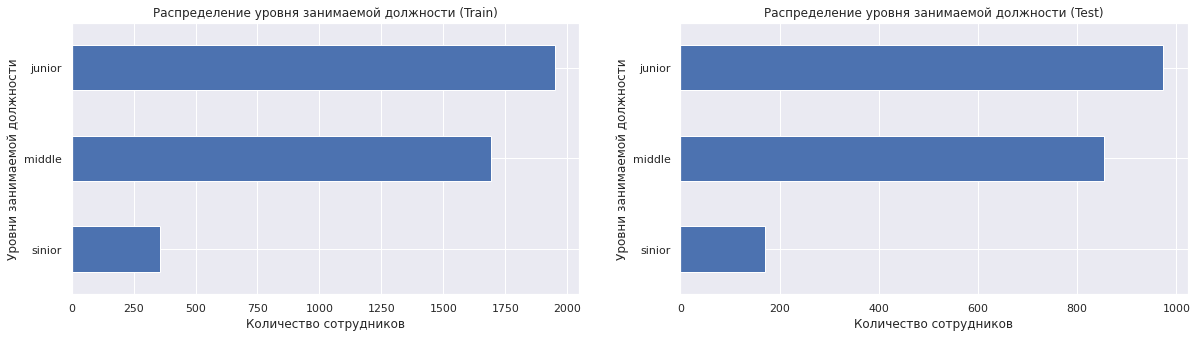

In [ ]:
data1 = train_quit['level'].value_counts().sort_values()
data2 = test_features_q['level'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение уровня занимаемой должности (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Уровни занимаемой должности')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение уровня занимаемой должности (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Уровни занимаемой должности')

plt.show()

В тренировочном и тестовом датасете больше позиций специалистов низкого уровня.

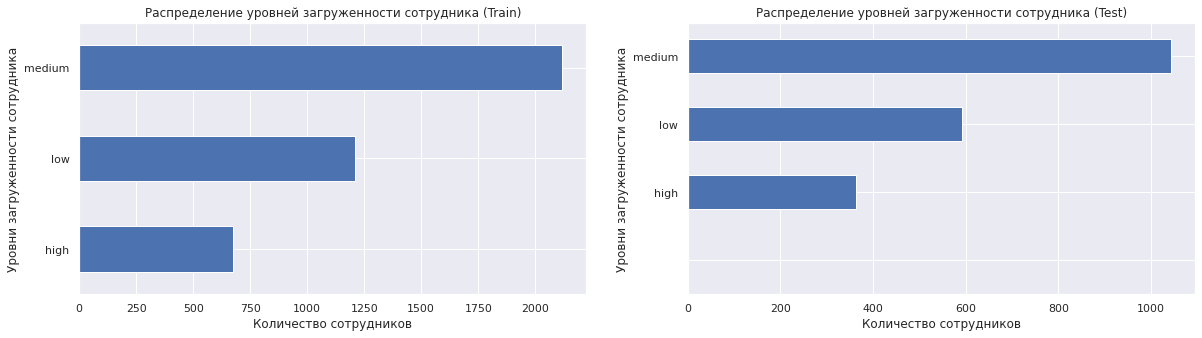

In [ ]:
data1 = train_quit['workload'].value_counts().sort_values()
data2 = test_features_q['workload'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение уровней загруженности сотрудника (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Уровни загруженности сотрудника')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение уровней загруженности сотрудника (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Уровни загруженности сотрудника')

plt.show()

Структура тестовой и тренировочной выборок схожи. Большее количество сотрудников имеют среднюю загруженность.

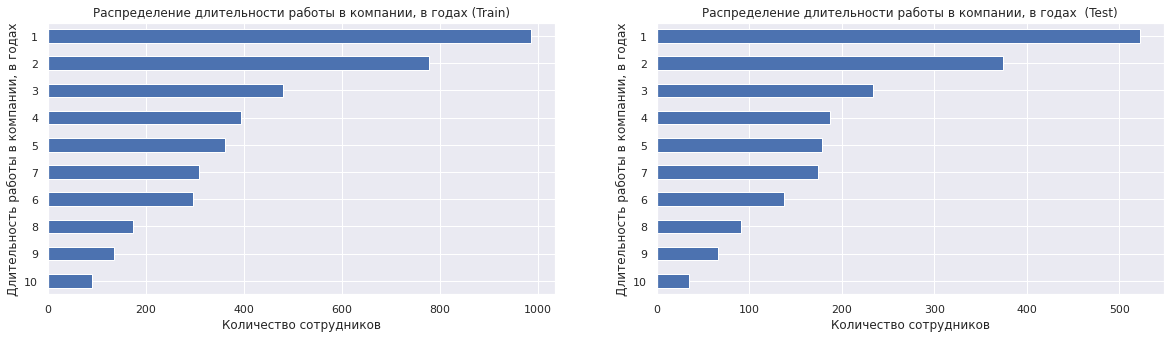

In [ ]:
data1 = train_quit['employment_years'].value_counts().sort_values()
data2 = test_features_q['employment_years'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение длительности работы в компании, в годах (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Длительность работы в компании, в годах')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение длительности работы в компании, в годах  (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Длительность работы в компании, в годах')

plt.show()

В компании много новичков. С увеличением длительности работы в компании, снижается количество сотрудников.

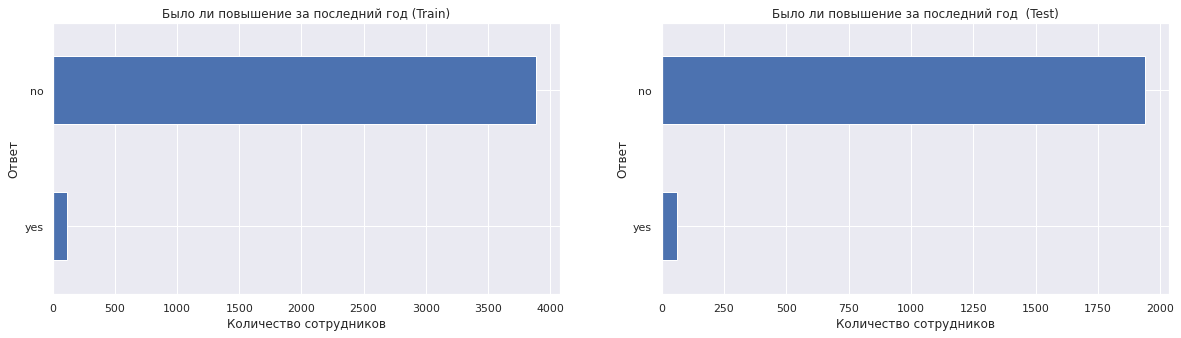

In [ ]:
data1 = train_quit['last_year_promo'].value_counts().sort_values()
data2 = test_features_q['last_year_promo'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Было ли повышение за последний год (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Ответ')

data2.plot.barh(ax=ax2)
ax2.set_title('Было ли повышение за последний год  (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Ответ')

plt.show()

Повышение получило минимальное количество сотрудников.

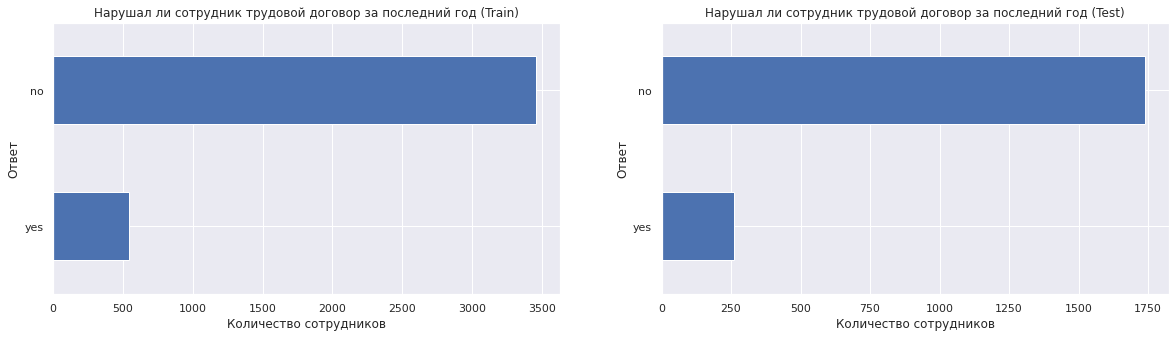

In [ ]:
data1 = train_quit['last_year_violations'].value_counts().sort_values()
data2 = test_features_q['last_year_violations'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Нарушал ли сотрудник трудовой договор за последний год (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Ответ')

data2.plot.barh(ax=ax2)
ax2.set_title('Нарушал ли сотрудник трудовой договор за последний год (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Ответ')

plt.show()

Большинство сотрудников не нарушает трудовой договор.

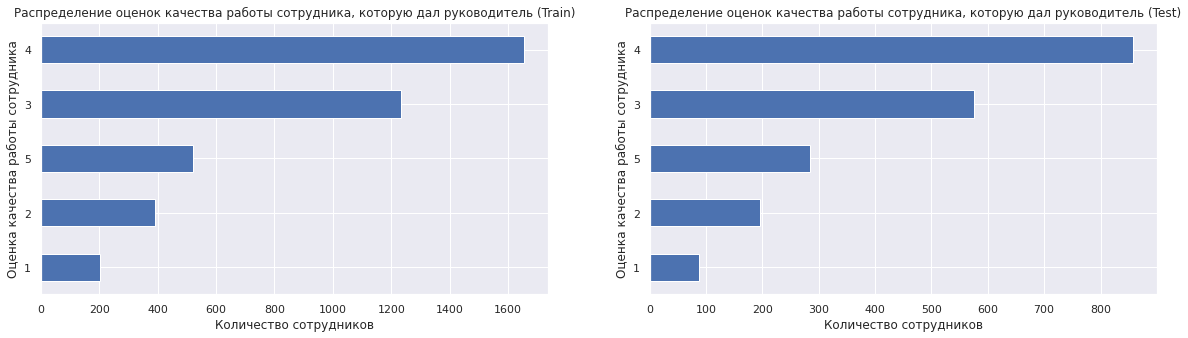

In [ ]:
data1 = train_quit['supervisor_evaluation'].value_counts().sort_values()
data2 = test_features_q['supervisor_evaluation'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Распределение оценок качества работы сотрудника, которую дал руководитель (Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Оценка качества работы сотрудника')

data2.plot.barh(ax=ax2)
ax2.set_title('Распределение оценок качества работы сотрудника, которую дал руководитель (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Оценка качества работы сотрудника')

plt.show()

Преобладают средние и высокие оценки.

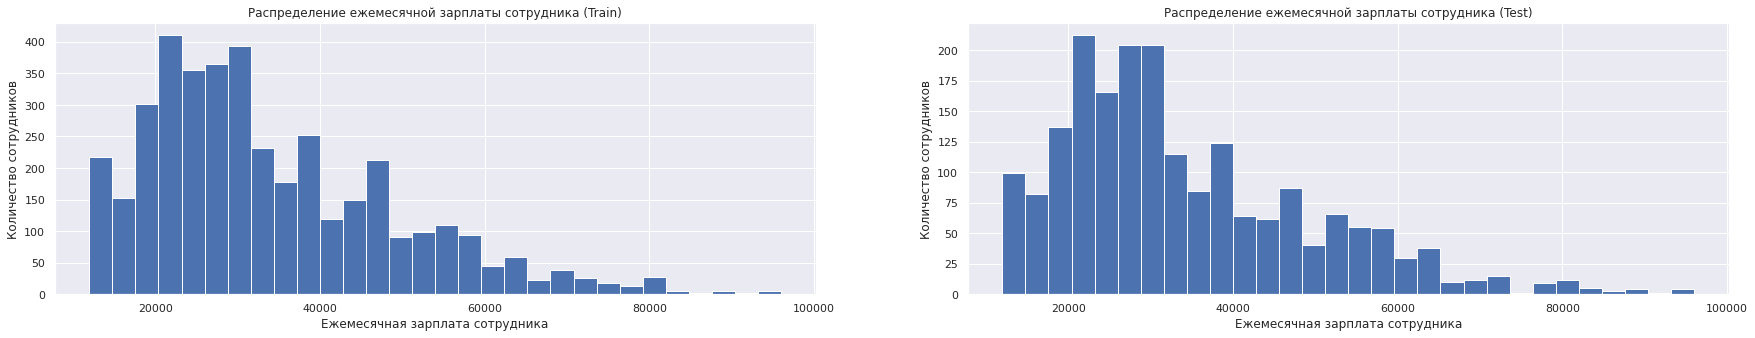

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5))

train_quit['salary'].hist(ax=ax1, bins=30)
ax1.set_title('Распределение ежемесячной зарплаты сотрудника (Train)')
ax1.set_xlabel('Ежемесячная зарплата сотрудника')
ax1.set_ylabel('Количество сотрудников')

test_features_q['salary'].hist(ax=ax2, bins=30)
ax2.set_title('Распределение ежемесячной зарплаты сотрудника (Test)')
ax2.set_xlabel('Ежемесячная зарплата сотрудника')
ax2.set_ylabel('Количество сотрудников')

plt.show()

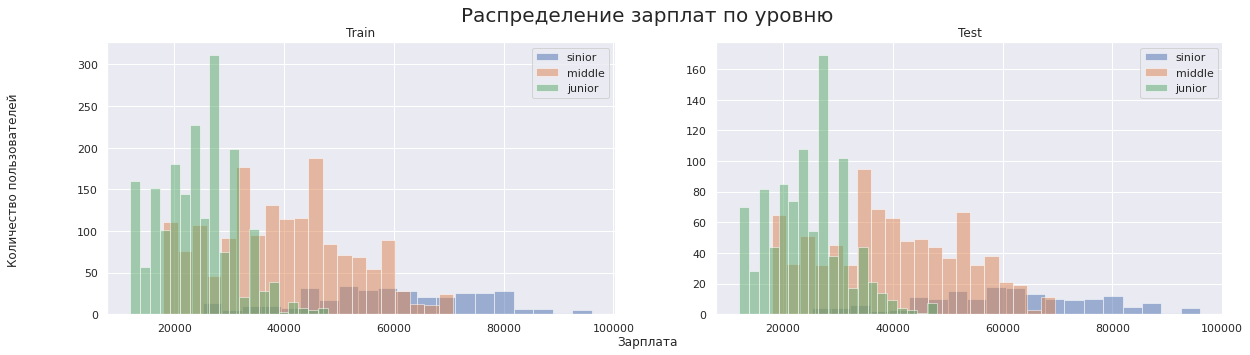

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
f.suptitle('Распределение зарплат по уровню', fontsize=20)

f.text(0.5, 0.04, 'Зарплата', ha='center')
f.text(
    0.06,
    0.5,
    'Количество пользователей',
    ha='center',
    va='center',
    rotation='vertical',
)

ax1.hist(
    train_quit.query('level == "sinior"')['salary'],
    bins=20,
    alpha=0.5,
    label='sinior',
)
ax1.hist(
    train_quit.query('level == "middle"')['salary'],
    bins=20,
    alpha=0.5,
    label='middle',
)
ax1.hist(
    train_quit.query('level == "junior"')['salary'],
    bins=20,
    alpha=0.5,
    label='junior',
)
ax1.set_title('Train')
ax1.legend()

ax2.hist(
    test_features_q.query('level == "sinior"')['salary'],
    bins=20,
    alpha=0.5,
    label='sinior',
)
ax2.hist(
    test_features_q.query('level == "middle"')['salary'],
    bins=20,
    alpha=0.5,
    label='middle',
)
ax2.hist(
    test_features_q.query('level == "junior"')['salary'],
    bins=20,
    alpha=0.5,
    label='junior',
)
ax2.set_title('Test')
ax2.legend()

plt.show()

Зарплата также зависит от уровня занимаемой должности. Квалификация сотрудника повышает шанс получить более высокую зарплату.

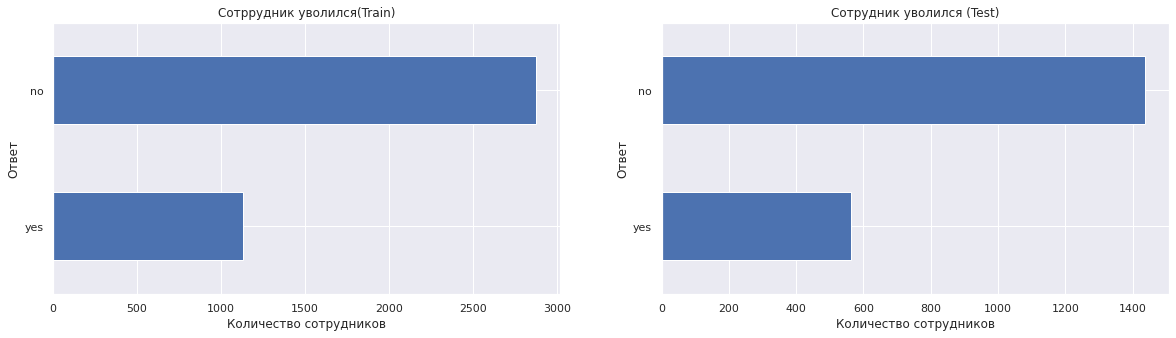

In [ ]:
data1 = train_quit['quit'].value_counts().sort_values()
data2 = test_target_quit['quit'].value_counts().sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data1.plot.barh(ax=ax1)
ax1.set_title('Сотррудник уволился(Train)')
ax1.set_xlabel('Количество сотрудников')
ax1.set_ylabel('Ответ')

data2.plot.barh(ax=ax2)
ax2.set_title('Сотрудник уволился (Test)')
ax2.set_xlabel('Количество сотрудников')
ax2.set_ylabel('Ответ')

plt.show()

Уволилось чуть больше трети сотрудников.

**3.2. Портрет «уволившегося сотрудника»**
<a href="2.3.2"></a>

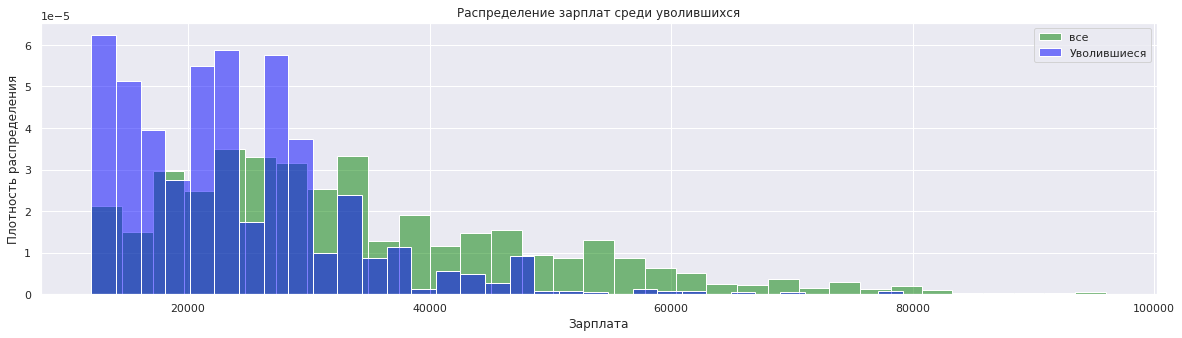

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Распределение зарплат среди уволившихся')
sns.histplot(
    train_quit['salary'],
    stat='density',
    common_norm=False,
    alpha=0.5,
    label='все',
    color='green',
    ax=ax,
)
sns.histplot(
    train_quit.query('quit == "yes"')['salary'],
    stat='density',
    common_norm=False,
    alpha=0.5,
    label='Уволившиеся',
    color='blue',
    ax=ax,
)
ax.set(xlabel='Зарплата', ylabel='Плотность распределения')
ax.legend()
plt.show()

In [ ]:
round(
    train_quit.query('quit == "yes"')['salary'].mean()
    / train_quit.query('quit == "no"')['salary'].mean(),
    2,
)

0.63

Чаще увольняются сотрудники с низкими зарплатами. Зарплата уволившихся сотрудников в среднем на 37% ниже оставшихся. Можно предположить, что они ищут более доходные место, что вполне логично.

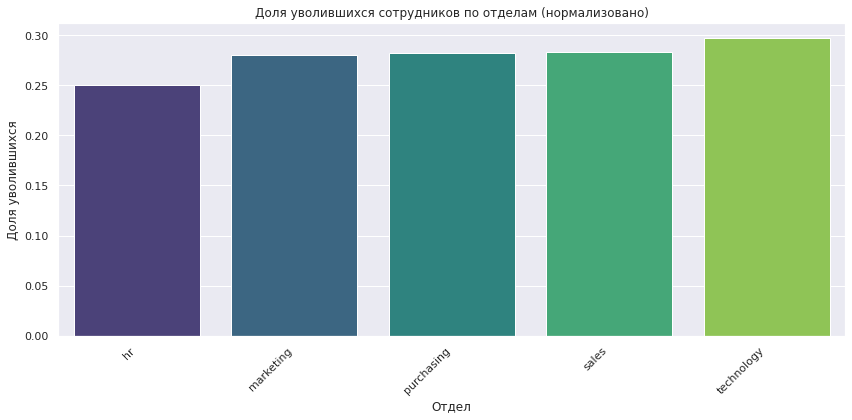

In [ ]:
quit_by_dept_normalized = (
    train_quit.groupby(['dept'])['quit']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

plt.figure(figsize=(12, 6))
sns.barplot(x=quit_by_dept_normalized.index, y=quit_by_dept_normalized['yes'], palette='viridis')
plt.title('Доля уволившихся сотрудников по отделам (нормализовано)')
plt.xlabel('Отдел')
plt.ylabel('Доля уволившихся')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Видим, что наибольшее количество сотрудников уволилось в отделе продаж и технологий.

**3.3. Проверим утвверждение аналитиков, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник**
<a href="2.3.3"></a>

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Для этого на тренировочной выборке предскажем показатель, воспользовавшись нашей лучшей моделью, а на тестовой выборке - воспользуемся результатами из предыдущей задачи.

In [ ]:
portrait = pd.merge(test_target_quit, test_target_job_satisfaction_rate, on='id', sort=True).sort_values(by='id')

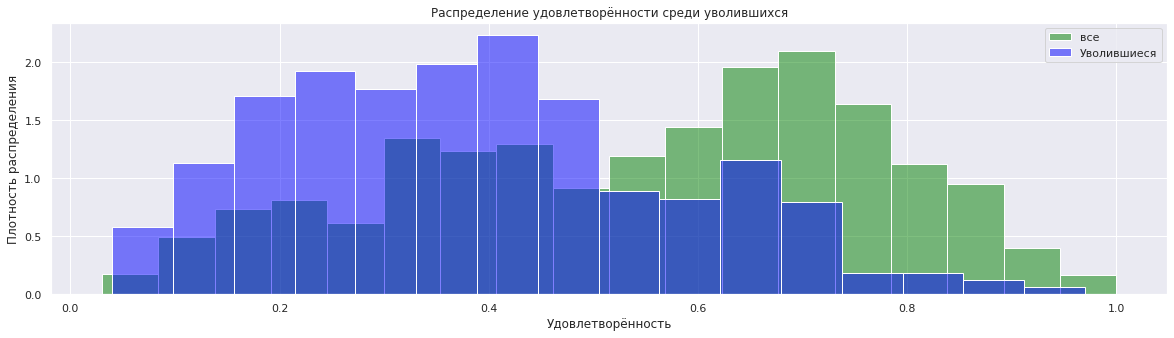

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Распределение удовлетворённости среди уволившихся')
sns.histplot(
    portrait['job_satisfaction_rate'],
    stat='density',
    common_norm=False,
    alpha=0.5,
    label='все',
    color='green',
    ax=ax,
)
sns.histplot(
    portrait.query('quit == "yes"')['job_satisfaction_rate'],
    stat='density',
    common_norm=False,
    alpha=0.5,
    label='Уволившиеся',
    color='blue',
    ax=ax,
)
ax.set(xlabel='Удовлетворённость', ylabel='Плотность распределения')
ax.legend()
plt.show()

In [ ]:
round(
    portrait.query('quit == "yes"')['job_satisfaction_rate'].mean()
    / portrait.query('quit == "no"')['job_satisfaction_rate'].mean(),
    2,
)

0.63

Действительно, можно заметить, что в среднем уровень удовлетворённости уволившихся на 37% ниже оставшихся.

**Вывод:**

1)train_quit и test_features_q:
- `dept:`
Видно, что структура в целом очень похожа.
- `level:`
В тренировочном и тестовом датасете больше позиций специалистов низкого уровня.
- `workload:`
Структура тестовой и тренировочной выборок схожи. Большее количество сотрудников имеют среднюю загруженность.
- `employment_years:`
В компании много новичков. С увеличением длительности работы в компании, снижается количество сотрудников.
- `last_year_promo:`
Повышение получило минимальное количество сотрудников.
- `last_year_violations:`
Большинство сотрудников не нарушает трудовой договор.
- `supervisor_evaluation:`
Преобладают средние и высокие оценки.
- `salary:`
Зарплата также зависит от уровня занимаемой должности. Квалификация сотрудника повышает шанс получить более высокую зарплату.

2)train_quit и test_target_quit:
- `dept:`
Уволилось чуть больше трети сотрудников.

3)Портрет «уволившегося сотрудника»:
- Чаще увольняются сотрудники с низкими зарплатами. Зарплата уволившихся сотрудников в среднем на 37% ниже оставшихся. Можно предположить, что они ищут более доходные место, что вполне логично.
- Видим, что наибольшее количество сотрудников уволилось в отделе продаж и технологий.

4)Проверим утвверждение аналитиков, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник:
Действительно, можно заметить, что `в среднем уровень удовлетворённости уволившихся на 37% ниже оставшихся.`

## 4. Добавление нового входного признака
<a href="2.4"></a>

In [ ]:
train_quit['job_satisfaction_rate'] = rs.predict(train_quit)
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   object 
 10  job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB


In [ ]:
test_features_q['job_satisfaction_rate'] = rs.predict(test_features_q)
test_features_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
train_quit = train_quit.sort_values(by=['id']).set_index('id')
test_features_q = test_features_q.sort_values(by=['id']).set_index('id')

**Корреляционный анализ**

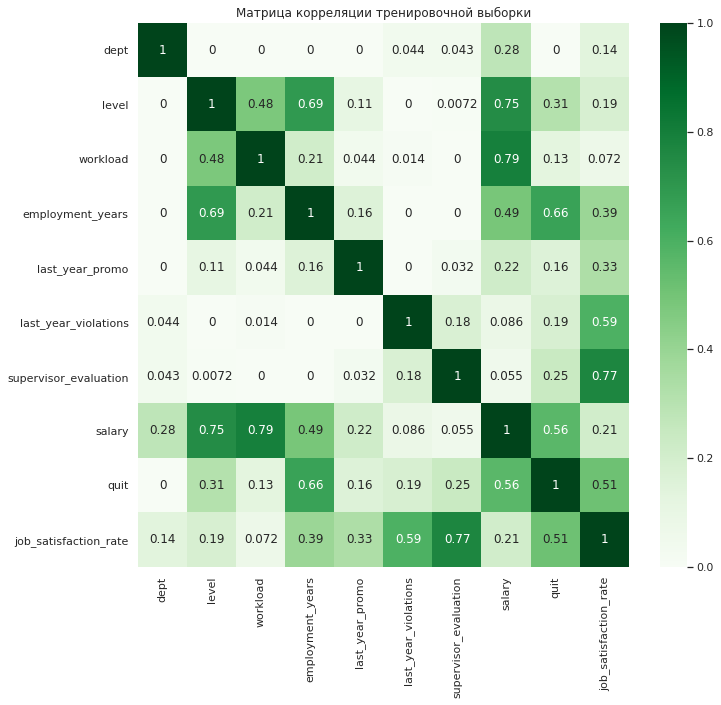

In [ ]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.title('Матрица корреляции тренировочной выборки')
sns.heatmap(train_quit.phik_matrix(interval_cols=
    ['id','employment_years','supervisor_evaluation', 'salary','job_satisfaction_rate']),
    annot=True,
    cmap="Greens");

In [ ]:
test_features_q = pd.merge(test_features_q, test_target_quit, on='id', sort=True)
print(test_features_q.info())
test_features_q.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,100298,hr,junior,low,2,no,no,4,19200,0.820000,no
1,100480,marketing,junior,low,4,no,no,4,16800,0.850000,no
2,100503,purchasing,middle,high,5,no,no,4,55200,0.710000,no
3,100610,sales,middle,medium,5,no,no,4,43200,0.814000,no
4,100692,sales,middle,high,6,no,no,4,48000,0.703333,no


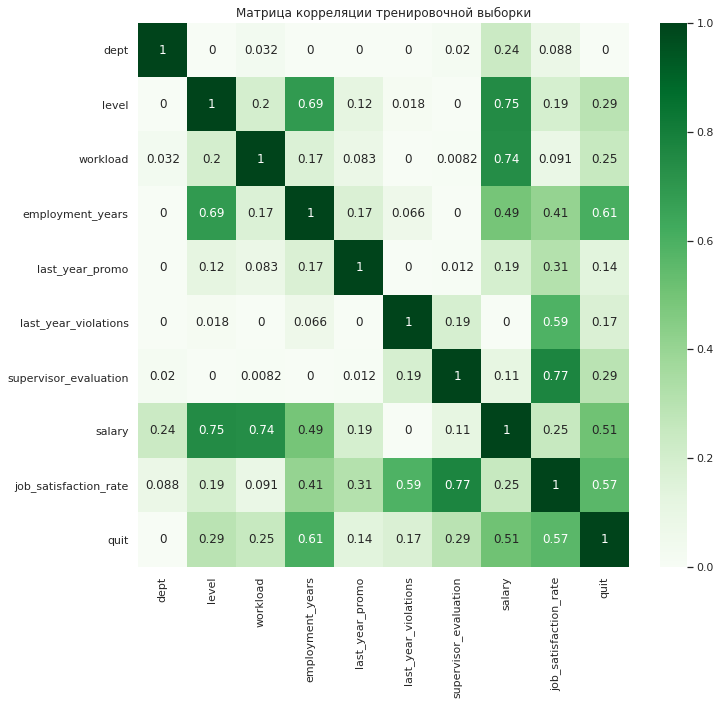

In [ ]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.title('Матрица корреляции тренировочной выборки')
sns.heatmap(test_features_q.drop(columns=['id']).phik_matrix(interval_cols=
    ['id','employment_years','supervisor_evaluation', 'salary','job_satisfaction_rate']),
    annot=True,
    cmap="Greens");

## 5. Подготовка данных
<a href="2.5"></a>

In [ ]:
le = LabelEncoder()
le.fit_transform(train_quit['quit'].unique())

array([1, 0])

In [ ]:
train_quit['quit'] = le.transform(train_quit['quit'])
test_features_q['quit'] = le.transform(test_features_q['quit'])

In [ ]:
X_train_2 = train_quit.drop('quit', axis=1)
y_train_2 = train_quit['quit']

In [ ]:
X_test_2 = test_features_q.drop('quit', axis=1)
y_test_2 = test_features_q['quit']

In [ ]:
num_columns = ['employment_years',
               'supervisor_evaluation',
               'salary',
               'job_satisfaction_rate']

In [ ]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
X_train_2_transformed = pd.DataFrame(data_preprocessor.fit_transform(X_train_2), columns=data_preprocessor.get_feature_names_out())
X_train_2_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ohe__dept_marketing            4000 non-null   float64
 1   ohe__dept_purchasing           4000 non-null   float64
 2   ohe__dept_sales                4000 non-null   float64
 3   ohe__dept_technology           4000 non-null   float64
 4   ohe__last_year_promo_yes       4000 non-null   float64
 5   ohe__last_year_violations_yes  4000 non-null   float64
 6   ord__level                     4000 non-null   float64
 7   ord__workload                  4000 non-null   float64
 8   num__employment_years          4000 non-null   float64
 9   num__supervisor_evaluation     4000 non-null   float64
 10  num__salary                    4000 non-null   float64
 11  num__job_satisfaction_rate     4000 non-null   float64
dtypes: float64(12)
memory usage: 375.1 KB


In [ ]:
X_test_2_transformed = pd.DataFrame(data_preprocessor.transform(X_test_2), columns=data_preprocessor.get_feature_names_out())
X_test_2_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ohe__dept_marketing            2000 non-null   float64
 1   ohe__dept_purchasing           2000 non-null   float64
 2   ohe__dept_sales                2000 non-null   float64
 3   ohe__dept_technology           2000 non-null   float64
 4   ohe__last_year_promo_yes       2000 non-null   float64
 5   ohe__last_year_violations_yes  2000 non-null   float64
 6   ord__level                     2000 non-null   float64
 7   ord__workload                  2000 non-null   float64
 8   num__employment_years          2000 non-null   float64
 9   num__supervisor_evaluation     2000 non-null   float64
 10  num__salary                    2000 non-null   float64
 11  num__job_satisfaction_rate     2000 non-null   float64
dtypes: float64(12)
memory usage: 187.6 KB


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train_2_transformed.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,-2.0,-0.470588,-0.594286
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,-1.0,-0.411765,-0.582857
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.50,0.0,-0.058824,0.245714
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.25,0.0,1.882353,0.360000
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.25,0.0,-0.235294,0.842143


## 6. Обучение модели
<a href="2.6"></a>

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE, probability=True))
])

In [ ]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__criterion': ['gini', 'entropy', 'log_loss'],
        'models__splitter': ['best', 'random'],
        'models__max_depth': [None] + [i for i in range(2, 7)], #range(1, 700),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'models__max_leaf_nodes': range(1, 270),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },


    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [ ]:
rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на на кросс-валидации:', rs.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [ ]:
all_model_2 = pd.DataFrame(rs.cv_results_).sort_values(by=['rank_test_score']).head(10)
all_model_2[['rank_test_score', 'mean_test_score', 'param_models', 'params']]

,rank_test_score,mean_test_score,param_models,params
2,1,0.928645,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(random_state=42)}"
6,2,0.926839,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__splitter': 'best', 'models__min_samples_split': 9, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 61, 'models__max_depth': 5, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(random_state=42)}"
5,3,0.923502,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__splitter': 'random', 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_leaf_nodes': 86, 'models__max_depth': 6, 'models__criterion': 'gini', 'models': DecisionTreeClassifier(random_state=42)}"
3,4,0.917086,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__splitter': 'random', 'models__min_samples_split': 2, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 79, 'models__max_depth': None, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(random_state=42)}"
4,5,0.916693,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__splitter': 'random', 'models__min_samples_split': 9, 'models__min_samples_leaf': 4, 'models__max_leaf_nodes': 216, 'models__max_depth': None, 'models__criterion': 'gini', 'models': DecisionTreeClassifier(random_state=42)}"
7,6,0.915529,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__splitter': 'random', 'models__min_samples_split': 4, 'models__min_samples_leaf': 5, 'models__max_leaf_nodes': 108, 'models__max_depth': 6, 'models__criterion': 'entropy', 'models': DecisionTreeClassifier(random_state=42)}"
1,7,0.904772,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__splitter': 'random', 'models__min_samples_split': 5, 'models__min_samples_leaf': 7, 'models__max_leaf_nodes': 50, 'models__max_depth': 5, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(random_state=42)}"
0,8,0.902929,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__splitter': 'random', 'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 31, 'models__max_depth': 5, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(random_state=42)}"
8,9,0.898820,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 3, 'models__min_samples_leaf': 7, 'models__max_leaf_nodes': 147, 'models__max_depth': 3, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(random_state=42)}"
9,9,0.898820,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 3, 'models__min_samples_leaf': 9, 'models__max_leaf_nodes': 67, 'models__max_depth': 3, 'models__criterion': 'entropy', 'models': DecisionTreeClassifier(random_state=42)}"


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


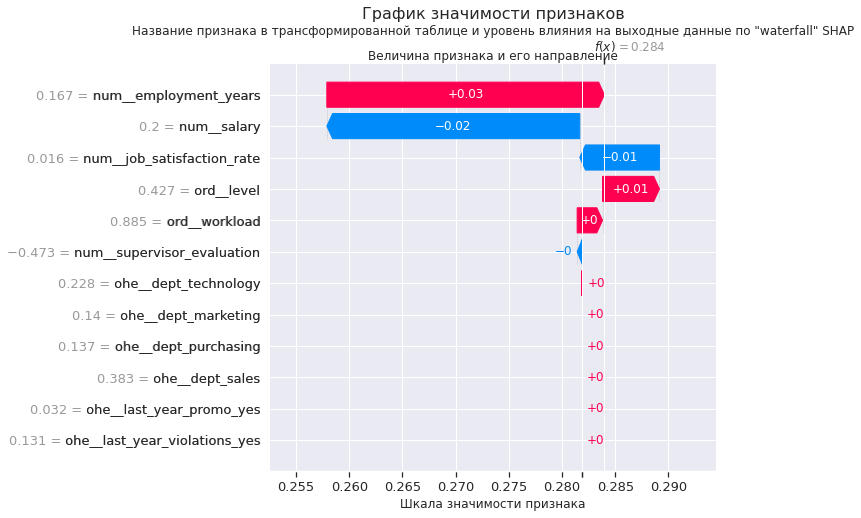

In [ ]:
best_model = rs.best_estimator_

X_transformed = pd.DataFrame(best_model.named_steps['preprocessor'].transform(X_test_2),
                             columns=best_model.named_steps['preprocessor'].get_feature_names_out())

explainer = shap.TreeExplainer(best_model.named_steps['models'])

shap_values = explainer(X_transformed)

shap_values_sum = 0
for i in range(1, len(shap_values)):
    shap_values_sum += shap_values[i]

shap.plots.waterfall(((shap_values_sum / len(shap_values))[:,1]), max_display=20, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_title('График значимости признаков', fontsize=16)
ax.set_xlabel('Название признака в трансформированной таблице и уровень влияния на выходные данные по "waterfall" SHAP')
ax.set_ylabel('Урые данные модели)', fontsize=14)

cb_ax0 = fig.axes[0]
cb_ax0.set_xlabel('Шкала значимости признака')

cb_ax1 = fig.axes[1]
cb_ax1.tick_params( labelsize=0)
cb_ax1.set_xlabel('Величина признака и его направление')

plt.show()


Проверим лучшую модель на соответствие условию: ROC-AUC ≥ 0.91 на тестовой выборке.

In [ ]:
roc_auc_rs_test = roc_auc_score(y_test_2, rs.predict_proba(X_test_2)[:, 1])
if (roc_auc_rs_test >= 0.91):
    print ('Модель удовлетворяет условию: на тестовой выборке ROC-AUC', round(roc_auc_rs_test, 4), '>= 0.91')
else:
    print('Модель не удовлетворяет условию:  ROC-AUC на тестовой выборке >= 0.91 n\ ТРЕБУЕТСЯ ДОПОЛНИТЕЛЬНОЕ ИССЛЕДОВАНИЕ')

Модель удовлетворяет условию: на тестовой выборке ROC-AUC 0.919 >= 0.91


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## 7. Промежуточные выводы
<a href="2.7"></a>

Для начала загрузили данные и посмотрели общую информацию.
На этапе предобработки проверили есть ли явные и неявные дубликаты, заменили ' ' на nan.
Провели исследовательский и корреляционный анализ. Аномалий и мультиколинеарность не обнаружены.

В процессе обучения моделей и подбора параметров работа производилась для:
1. LinearRegression()
2. DecisionTreeRegressor()

`Лучшая модель:`
DecisionTreeClassifier(random_state=42)

`Параметры:`
{'preprocessor__num': RobustScaler(), 'models__splitter': 'best', 'models__min_samples_split': 7, 'models__min_samples_leaf': 3, 'models__max_leaf_nodes': 30, 'models__max_depth': 6, 'models__criterion': 'log_loss', 'models': DecisionTreeClassifier(random_state=42)}

`Метрика лучшей модели на на кросс-валидации:`
0.928645


## *Общий вывод*
<a href="3"></a>

`Цель:` оптимизировать управление персоналом и предложить бизнесу, как избежать финансовых потерь из-за оттока сотрудников.

`Задачи:`
- Предсказание уровня удовлетворённости сотрудника: необходимо построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

- Предсказание увольнения сотрудника из компании: необходимо построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

`Задача 1`

*1. Загрузка данных:*
- загрузили данные;
- получили общую информацию.

*2. Предобработка данных*
- проверили наличие явных и неявных дубликатов;
- заменили ' ' на nan.

*3. Исследовательский анализ данных:*  
- рассмотрели каждую категорию;
- рассмотрели распределение зарплат по уровню квалификации;
- зарплата зависит от уровня занимаемой должности;
- квалификация сотрудника повышает шанс получить более высокую зарплату;
- сотрудники в целом скорее удовлетворены работой;
- корреляяционный анализ.

*4. Подготовка данных:*
- определили размерности датасетов;
- использовали два кодировщика: OneHotEncoder, OrdinalEncoder.

*5. Обучение моделей:*
- определили лучшую модель: DecisionTreeRegressor(max_features=9, random_state=42).

*6. Промежуточные выводы*

`Задача 2`


*1. Загрузка данных*
- загрузили данные;
- получили общую информацию.

*2. Предобработка данных*
- проверили наличие явных и неявных дубликатов;
- заменили ' ' на nan.

*3. Исследовательский анализ данных:*
- проанализировали каждую категорию;
- составили портрет «уволившегося сотрудника»:
    - чаще увольняются сотрудники с низкими зарплатами;
    - наибольшее количество сотрудников уволилось в отделе продаж и технологий.
- проверили связь увольнений и удовлетворённость сотрудника работой в компании.

*4. Добавление нового входного признака*
- добавили признак `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи;
- проверили отсутствие наличия мультиколлениарности в данных;

*5. Подготовка данных*

*6. Обучение модели*

*7. Промежуточные выводы*

`Рекомендации для компании`

Чаще увольняются сотрудники с низкими зарплатами. Зарплата уволившихся сотрудников в среднем на 37% ниже оставшихся.
Следует:
- пересмотреть уровень зарплат;
- скорректировать зарплату для удержания ключевых сотрудников;
- рассмотрить возможность предоставления других льгот, таких как бонусы за производительность, премии, участие в прибылях, расширенный пакет медицинского страхования, оплата обучения или возможности карьерного роста.

Наибольшее количество сотрудников уволилось в отделе продаж и технологий.
Следует:
- разработать планы карьерного развития для сотрудников, чтобы помочь им достичь своих профессиональных целей;
- оценить условия труда в этих отделах;
- предложить сотрудникам в отделах продаж и технологий возможности для обучения и профессионального развития;
- оптимизировать распределение задач и уменьшить рабочую нагрузку на сотрудников в отделах с высокой текучкой.